Open questions:
 - how to save/send .json to open it from url I don't want to get the data from local machine (gitlab open link)
 - reverse barh
 - add description

In [226]:
# если нужно установить ijson
#import sys
#!conda install --yes --prefix {sys.prefix} ijson

Читаем json и парсим его на 3 группы

In [5]:
# намеренно не включаем в выбрку prefix=item.textcomment.items.item.attachments.item.video.title 
# - они повторяют заголовки топиков

#812    prefix=item.text,value=Немного позанудствую... ДЛЯ ВОПРОСОВ ЕСТЬ СПЕЦИАЛЬНАЯ ТЕМА! 
#Ну правда, стена группы - плохое место для одинаковых вопросов. Может, закроем ее на лето, как обычно?

# для фильтра prefix == "item.text" and type == 'string' and value != '': при счетчике > 795 считать комментариями

# после распарсивания json'а стало видно, что текстовая информация лежит в следующих данных
# 0) тип данных String, значние, соответственно, непустое и
# 1) префикс равен item.text - это чисто текстовые посты
# 2) префикс, содержащий description - это тоже посты, но которые также содержат какой-то attachment (ссылка, подкаст, 
# альбом идт) и его описывают
# 3) префикс, содержащий textcomment и заканчивающийся на text - это комменты
#
# я решила рассматривать эти тексты, но разделить их на 3 группы:
# 1. комментарии - группа 3)
# 2. посты от админов группы - группа 2) и частично 3)
# 3. посты от участников группы - частично 3)
# А дело в том, что с какого-то момента админы группы решили закрыть стенку для комментариев участников (где-то в 2015) или 
# окончательно закрыть стенку, потому что раньше закрывали ее на ограниченный период. В общем, я на глаз определила 
#(магическое число 795 в коде), с какого
# момента посты на стене становятся прерогативой исключительно админа, и эти посты идут в группу 2., а где в постах было
# значительное количество постов от участников (посты админта там тоже есть, но сравнительно мало), и эта часть была выделена
# в отдельную группу "посты участников"

import re
import ijson

with open('letnyayashkola_vk.json', encoding = "utf8") as input_file:
    parser = ijson.parse(input_file)
    
    admin_posts = ''
    user_posts = ''
    comments = ''
    
    admin_posts_count = 0
    user_posts_count = 0
    comments_count = 0

    # когда посты на стене стали писать только админы
    wall_flag = 795
    wall_is_closed_for_users = 0;

    for prefix, type, value in parser:
        if type == 'string' and value != '':
            if re.search(".*textcomment.*text$", prefix):
                comments_count += 1
                comments = comments + ' ' + value
            elif re.search(".*description.*", prefix):
                admin_posts_count += 1
                admin_posts = admin_posts + ' ' + value
            elif prefix == "item.text" and wall_is_closed_for_users <= 795:
                wall_is_closed_for_users += 1;
                admin_posts_count += 1
                admin_posts = admin_posts + ' ' + value
            elif prefix == "item.text" and wall_is_closed_for_users > 795:
                user_posts_count += 1
                user_posts = user_posts + ' ' + value

Фунция, чтобы немного чистить текст и сформировать отсортированный словарь

In [4]:
def create_sorted_dict(text):
    # убрать пунктуацию и другие знаки
    punctuations = '''-[]{};:'"/\\/<>@#$%^&*_|—«»~=!().?,'''

    text = text.lower()
    
    # заменяем на пробелы, чтобы не слиплись слова в тех случаях, когда после запятой или точки не поставлен пробел
    # получается беда со ссылками, когда http www bla bla - это отдельные слова, но пусть это будет known issue
    for sybmol in text: 
        if sybmol in punctuations: 
            text = text.replace(sybmol, ' ')

    text_list = text.split()
    
    frequency_dict = {}
    
    # получаем частотный словарь
    for word in text_list:
        count = frequency_dict.get(word, 0)
        frequency_dict[word] = count + 1
    
    # сортируем частотный словарь
    sorted_tuples = sorted(frequency_dict.items(), key = lambda item: item[1], reverse = True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    sorted_frequency_dict = sorted_dict

    # убираем слова меньше 5 букв, за исключением "лш"
    for key in list(sorted_dict.keys()):
        if(len(key) <= 4 and key != 'лш'):
            sorted_frequency_dict.pop(key)
            
    return(sorted_frequency_dict)

        
print(create_sorted_dict(admin_posts))

NameError: name 'admin_posts' is not defined

Функция, чтобы обрезать датасет и показать минимальную статистику

In [3]:
def trim_dict(dict, trim_count = 20):

    all_unique_words_count = len(dict)
    all_words_count = 0
    frequent_words_count = 0

    final_dict = {}
    count = 0

    for key, value in dict.items():
        all_words_count = all_words_count + value
        if count < trim_count:
            count += 1
            frequent_words_count = frequent_words_count + value
            final_dict[key] = value

    print('Number of unique words :', all_unique_words_count)
    print('Number of all words :', all_words_count)
    print('Number of', trim_count, 'most frequent words :', frequent_words_count)
    print(str(trim_count) + ' most frequent words is '+ str(round(trim_count/all_unique_words_count*100, 2)) 
          + '% of unique words and ' + str(round(frequent_words_count/all_words_count*100, 2)) + '% of all words' )

    return(final_dict)

Функция, чтобы вывести гистограмму

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def create_hist(dict):
    
    fig, ax = plt.subplots(figsize = (15,15))   
    width = 0.5 # the width of the bars 
    ind = np.arange(len(dict))  # the x locations for the groups
    ax.barh(ind, dict.values(), width, color = "brown")
    ax.invert_yaxis()
    ax.set_yticks(ind + width/2)
    ax.set_yticklabels(dict.keys())

    plt.title('The most frequent words')
    plt.figure(figsize = (40, 40))

    for i, v in enumerate(dict.values()):
        ax.text(v, i, str(v), color = 'brown')

Запускаем

In [7]:
# Вывод размеров трех групп текстов
print('Comments :', comments_count, 'comments,', len(comments), 'symbols')
print('Admin posts :', admin_posts_count, 'posts,', len(admin_posts), 'symbols')
print('User posts :', user_posts_count, 'posts,', len(user_posts), 'symbols')

Comments : 14113 comments, 1232477 symbols
Admin posts : 1612 posts, 605300 symbols
User posts : 4019 posts, 951894 symbols


Number of unique words : 16662
Number of all words : 52728
Number of 50 most frequent words : 7076
50 most frequent words is 0.3% of unique words and 13.42% of all words


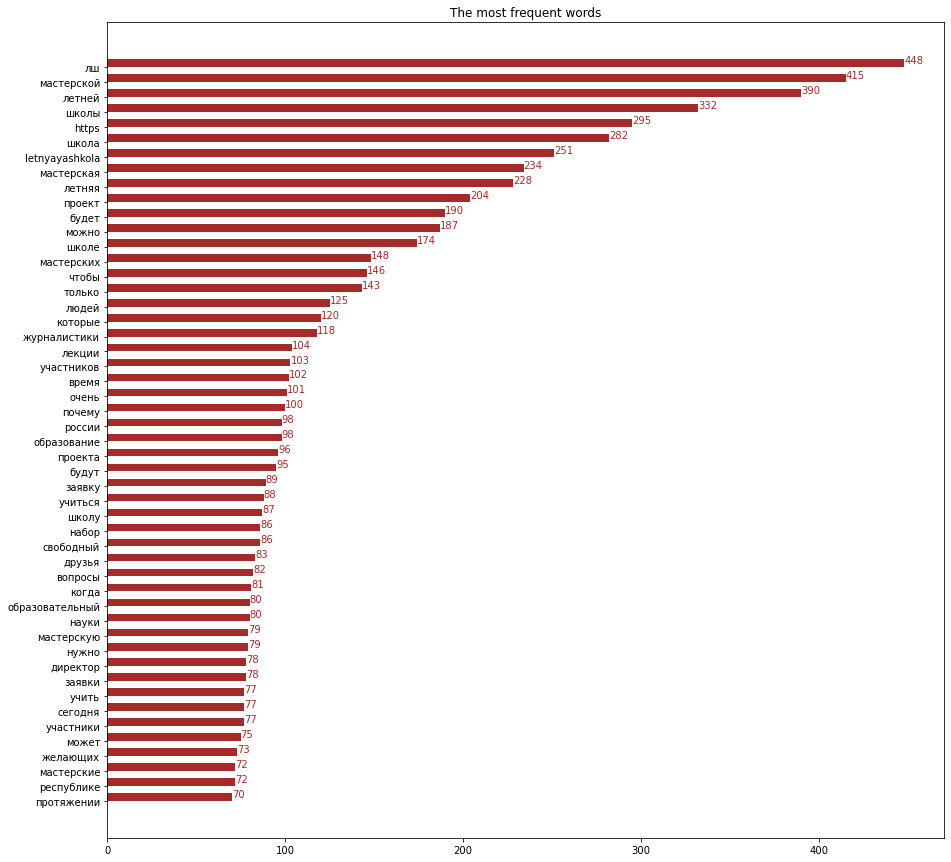

<Figure size 2880x2880 with 0 Axes>

In [16]:
# Вывод 50 самых частотных слов для постов админов
create_hist(trim_dict(create_sorted_dict(admin_posts), 50))

Number of unique words : 21928
Number of all words : 81080
Number of 50 most frequent words : 11206
50 most frequent words is 0.23% of unique words and 13.82% of all words


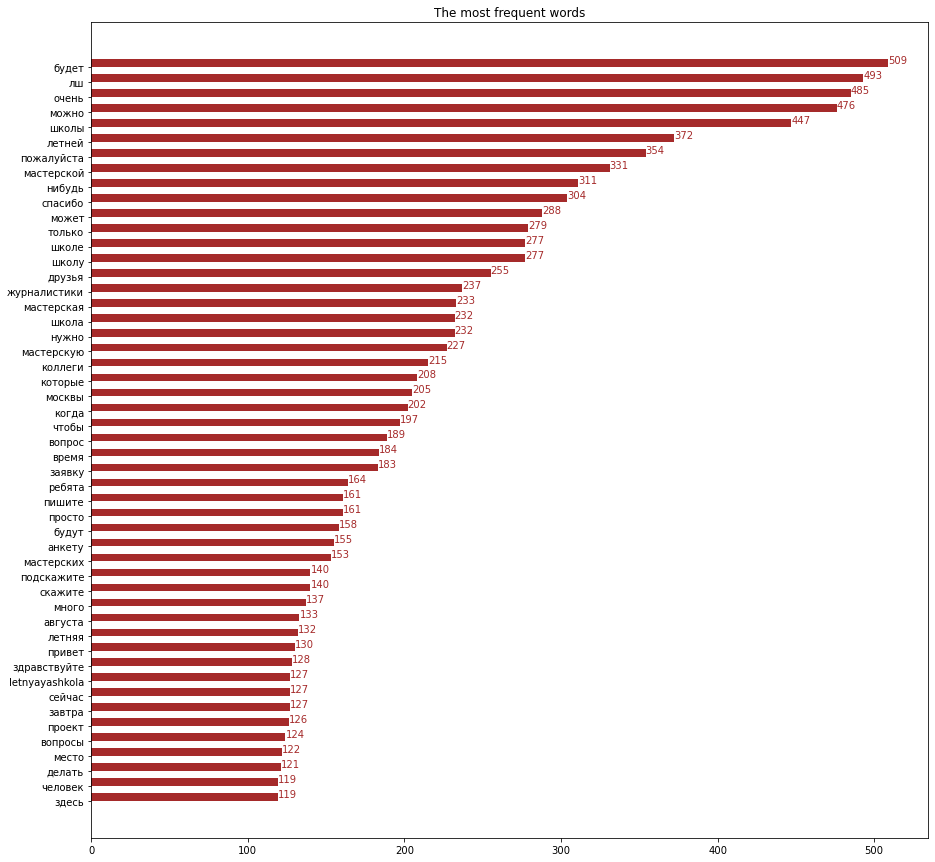

<Figure size 2880x2880 with 0 Axes>

In [17]:
# Вывод 50 самых частотных слов для постов пользователей
create_hist(trim_dict(create_sorted_dict(user_posts), 50))

Number of unique words : 26849
Number of all words : 101930
Number of 50 most frequent words : 13801
50 most frequent words is 0.19% of unique words and 13.54% of all words


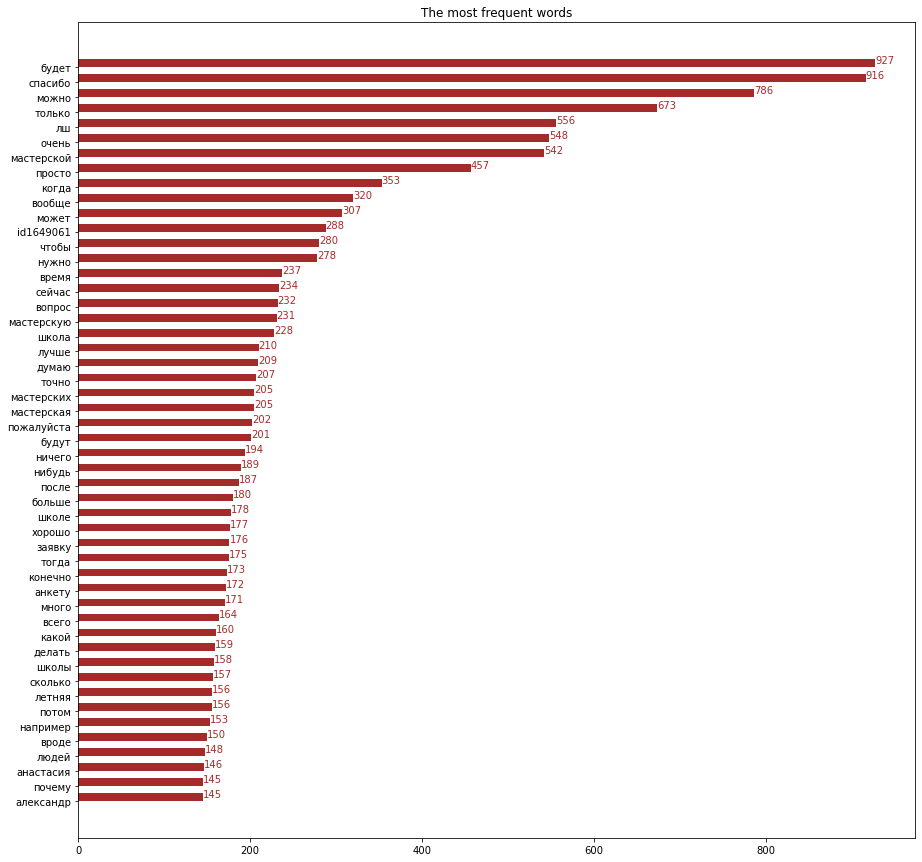

<Figure size 2880x2880 with 0 Axes>

In [18]:
# Вывод 50 самых частотных слов для комментариев
create_hist(trim_dict(create_sorted_dict(comments), 50))